## 이미지 10만장만 Select

In [1]:
# import glob
# import shutil
# import os

# src_dir = "../../data/CelebA/images/"
# dst_dir = "../../data/CelebA-30000/images/"

# os.mkdir('../../data/CelebA-30000')
# os.mkdir('../../data/CelebA-30000/images')
# for num, jpgfile in enumerate(glob.iglob(os.path.join(src_dir, "*.jpg"))):
#     if num >= 30000 : 
#         break;
#     shutil.copy(jpgfile, dst_dir)


In [2]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import torch.nn.init as init
from torch.utils.data import DataLoader

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import random

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# Create folders
if not os.path.exists('./checkpoint'):
    os.mkdir('./checkpoint')
    
if not os.path.exists('./dataset'):
    os.mkdir('./dataset')
    
if not os.path.exists('./img'):
    os.mkdir('./img')
    
if not os.path.exists('./img/real'):
    os.mkdir('./img/real')

if not os.path.exists('./img/fake'):
    os.mkdir('./img/fake')

# Load & Define Dataset

In [4]:
dataroot = '../../data/CelebA-30000'
image_size = 64
batch_size = 1000


dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, )

In [5]:
sample = next(iter(dataloader))

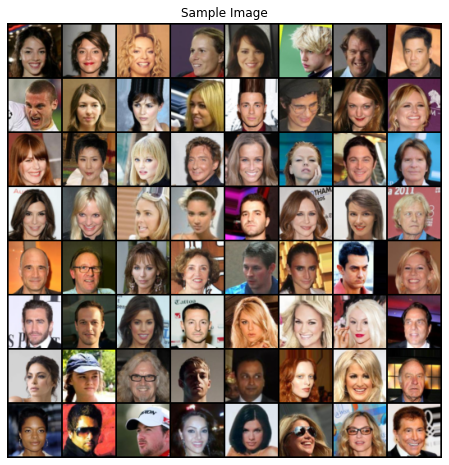

In [6]:
plt.figure(figsize = (8,8))
plt.axis('off')
plt.title('Sample Image')
plt.imshow(np.transpose(vutils.make_grid(sample[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Modeling

## 1.1 생성망

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
inp_dimm = 100
img_size = 64
out_chan = 3

In [9]:
class Generator(nn.Module) :
    def __init__(self) : 
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(inp_dimm, img_size * 8,4,1,0,bias = False),
            nn.BatchNorm2d(img_size*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(img_size * 8, img_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(img_size*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(img_size * 4, img_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(img_size*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(img_size * 2, img_size, 4, 2, 1, bias = False),
            nn.BatchNorm2d(img_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(img_size, out_chan, 4,2,1,bias=  False),
            nn.Tanh(),

        )

    def forward(self, x) : 
        return self.main(x)

## 1.2 판별망

In [10]:
class Discriminator(nn.Module) : 

    def __init__(self) : 
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(out_chan, img_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_size, img_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_size * 2, img_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_size * 4, img_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x) :
        x = self.main(x)
        return x
        

In [11]:
netG = Generator().to(device)
netG.apply(weights_init)
optimizerG = optim.Adam(netG.parameters(), lr = 0.00005)


netD = Discriminator().to(device)
netD.apply(weights_init)
optimizerD = optim.Adam(netD.parameters(), lr = 0.00005)

## sample

In [12]:
next(iter(dataloader))[0].size()

torch.Size([1000, 3, 64, 64])

In [13]:
sampleG = torch.randn((128,100,1,1)).to(device)
sampleD = torch.randn((128,3,64,64)).to(device)

g_out = netG(sampleG)
d_out = netD(sampleD)

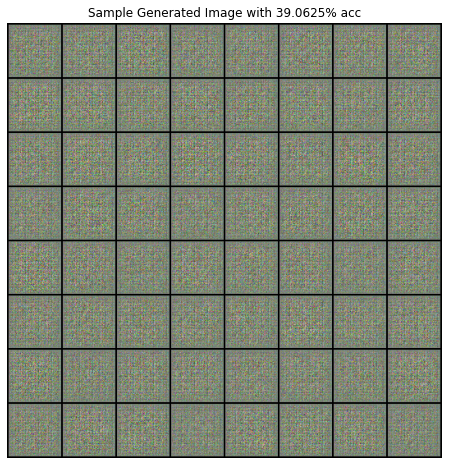

In [14]:
sample_gen_acc = ((d_out > 0.5) == 0).sum().item() / d_out.size(0) * 100
plt.figure(figsize = (8,8))
plt.axis('off')
plt.title(f'Sample Generated Image with {sample_gen_acc}% acc')
plt.imshow(np.transpose(vutils.make_grid(g_out[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Training

In [15]:
if 'used_noise.npy' in os.listdir() :
    fixed_noise = np.load('used_noise.npy')
    fixed_noise = torch.from_numpy(fixed_noise).to(device)
    print('기존 데이터를 불러옵니다.')
else : 
    fixed_noise = torch.randn(64,100,1,1).to(device)
    np.save('used_noise.npy', fixed_noise.cpu().detach().numpy())
    print('새로운 데이터를 불러옵니다.')

기존 데이터를 불러옵니다.


In [16]:
from glob import glob

In [17]:
netG_paths = glob('./checkpoint/netG*')
netG_paths = sorted(netG_paths, key = lambda x : int(x.split('_')[-1].replace('.pth','')))
netD_paths = glob('./checkpoint/netD*')
netD_paths = sorted(netD_paths, key = lambda x : int(x.split('_')[-1].replace('.pth','')))

In [18]:
try : 
    netG_path = netG_paths[-1]
    netD_path = netD_paths[-1]
    now_epoch = int(netG_paths[-1].split('_')[-1].replace('.pth','')) + 1
    netG.load_state_dict(torch.load(netG_path))
    netD.load_state_dict(torch.load(netD_path))
    print('기존 데이터를 불러옵니다.')
except : 
    now_epoch = 0
    print('새롭게 시작합니다.')

기존 데이터를 불러옵니다.


In [ ]:
criterion = nn.BCELoss()

n_epoch = 500

images = []
for epoch in range(now_epoch, n_epoch) :

    for i, (x, _) in enumerate(dataloader) : 
        netD.zero_grad()

        x = x.to(device)
        bs = x.size(0)

        true_label = torch.ones((bs,)).to(device) # Discriminator의 정답지
        netD_real = netD(x).view(-1)
        errD_real = criterion(netD_real, true_label)
        D_x = netD_real.mean().item()

        noise = torch.randn(bs,100,1,1).to(device)
        fake_x = netG(noise)
        false_label = torch.zeros((bs,)).to(device)
        netD_fake = netD(fake_x.detach()).view(-1)
        errD_fake = criterion(netD_fake, false_label)
        D_G_z1 = netD_fake.mean().item()

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        netG.zero_grad()
        gen_label = torch.ones((bs, )).to(device)
        gen_out = netD(fake_x).view(-1)
        errG = criterion(gen_out, gen_label)
        D_G_z2 = gen_out.mean().item()

        errG.backward()
        optimizerG.step()
    print(f'[{epoch} / {n_epoch}] Loss_D : {round(errD.item(),4)}, Loss_G : {round(errG.item(), 4)} // D(x) : {D_x}, D(G(z)) : {D_G_z1/D_G_z2}')

    fake = netG(fixed_noise)
    images.append(fake)

    torch.save(netG.state_dict(), './checkpoint/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), './checkpoint/netD_epoch_%d.pth' % (epoch))

    if epoch % 10 == 0 :
        with torch.no_grad() : 
            fake = netG(fixed_noise)
            plt.axis('off')
            plt.title(f'Sample Generated Image')
            plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()

# Load & Generate Images

In [19]:
from celluloid import Camera

MovieWriter ffmpeg unavailable; using Pillow instead.


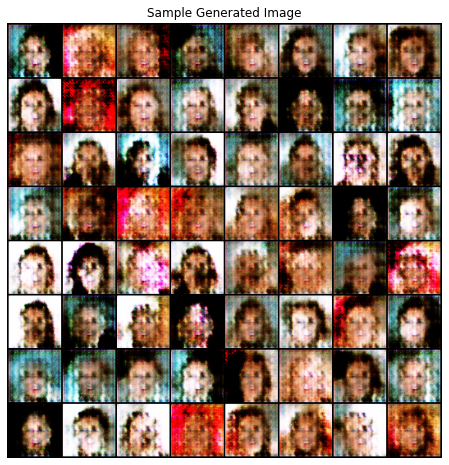

In [20]:
fig = plt.figure(figsize=(8,8))
camera = Camera(fig)
for path in netG_paths : 
    netG.load_state_dict(torch.load(path))
    image = netG(fixed_noise)
    plt.axis('off')
    plt.title(f'Sample Generated Image')
    plt.imshow(np.transpose(vutils.make_grid(image, padding=2, normalize=True).cpu(),(1,2,0)))
    camera.snap()
animation = camera.animate()
animation.save('Generation.gif')